# Random Network Distillation : Curiosity Driven Learning

All the details of this notebook adapted from these resources. This notebook doesn't include theoritical explanations.

* **Tutorial**: [medium RND Tutorial](https://medium.com/data-from-the-trenches/curiosity-driven-learning-through-random-network-distillation-488ffd8e5938)
* **DI-Engine Doc**: [OpenDILab-RND](https://opendilab.github.io/DI-engine/12_policies/rnd.html)
* **Paper**: [Exploration by Random Network Distillation](https://arxiv.org/pdf/1810.12894v1)
* **Montezuma Revenge Implementation RND**: [Pytorch Implementation of Medium RND Tutorial](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/tree/master/RND%20Montezuma's%20revenge%20PyTorch)
* **Montezuma RND Agent Play**: [See Agent Play - Youtube](https://youtu.be/fsFAE72GVlc?si=t9NQcYsWRk2aM891)
* **Original RND Adapted**: [RND by jcwleo](https://github.com/jcwleo/random-network-distillation-pytorch)
* **RND On Montezuma & Mario Bros Using Both RNN & CNN Policy**: [PPO Impl of RND using both RNN & CNN](https://github.com/alirezakazemipour/PPO-RND/tree/main)
* **OpenAI RND**: [OpenAI Implementation with Blog](https://github.com/openai/random-network-distillation)

This notebook is dedicated for **Super-mario-bros**. If you want to run **Montezuma Revenge**, then go to this notebook: [Montezuma-revenge](https://www.kaggle.com/code/syedjarullahhisham/drl-extra-personal-unit-5-rnd-montezuma-mario-bros)


# Comparison of Next-State Prediction With RND

<img src="https://images.ctfassets.net/kftzwdyauwt9/cad40f1b-77ca-4ac0-2774f03f998d/feedc7ac32900142614440a86e85d22e/nextstate-vs-rnd-stacked-5.svg?w=1920&q=90&fm=webp" alt="RND-compare" />

* $o_i$: Observation
* $a_i$: Action
* $f_i$: Feature
* $r_i$: Reward

## Import 

In [1]:
!pip install tensorboardX
!pip install gym
!pip install gym-super-mario-bros

!pip install gym[classic_control]

!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 1.3 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:0000:0100:01
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=48172 sha256=81b39b889d70132dc37a6fe7e644951500eead37c08c1e4d8e55d7b64ac46870
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
ERROR: pip's dependency resolver does not currently take into account 

In [162]:
!apt install swig cmake
!pip install swig

!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.1

!pip install moviepy==1.0.3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (4.0.1-5build1).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 84 not upgraded.
Hit:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:2 https://packages.cloud.google.com/apt cloud-sdk InRelease     
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease              
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Hit:5 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease    
Fetched 256 kB in 1s (308 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       


In [ ]:
import os
os.kill(os.getpid(), 9)

In [183]:
TRAIN = False
EVALUATE = True

In [3]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [163]:
import configparser
import math

import numpy as np

import torch
from torch import inf

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn import init

from torch.distributions.categorical import Categorical

from torch.multiprocessing import Pipe, Process

import gym
import cv2
import pickle
import shimmy

from abc import abstractmethod
from collections import deque
from copy import copy

from tensorboardX import SummaryWriter

import gym_super_mario_bros
# from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv   # old
from nes_py.wrappers import JoypadSpace   # updated
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

from PIL import Image

from matplotlib.animation import FuncAnimation
from matplotlib import animation
import matplotlib.pyplot as plt
import matplotlib

from IPython.display import HTML

from pathlib import Path
import datetime
import json
import imageio
import IPython
import base64
from base64 import b64encode

import warnings
warnings.filterwarnings("ignore")

# Config

In [5]:
%%writefile config.conf
[DEFAULT]
TrainMethod = RND
EnvType = mario
EnvID = SuperMarioBros-v0
MaxStepPerEpisode = 18000
LearningRate = 1e-4
NumEnv = 128
NumStep = 128
Gamma = 0.999
IntGamma = 0.99
Lambda = 0.95
StableEps = 1e-8
StateStackSize = 4
PreProcHeight = 84
ProProcWidth = 84
UseGAE = True
UseGPU = True
UseNorm = False
UseNoisyNet = False
ClipGradNorm = 0.5
Entropy = 0.001
Epoch = 4
MiniBatch = 4
PPOEps = 0.1
ExtCoef = 5.
IntCoef = 1.
StickyAction = True
ActionProb = 0.25
UpdateProportion = 0.25
LifeDone = False
ObsNormStep = 50

[OPTIONS]
EnvType = [atari, mario]

Overwriting config.conf


In [6]:
config = configparser.ConfigParser()
config.read('./config.conf')

# ---------------------------------
default = 'DEFAULT'
# ---------------------------------
default_config = config[default]

## Model Util

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# PPO Policy Model

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*9A7Fxb_RVb2_dKOQ" alt="ppo-arch" />

In [8]:
class PPOModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(PPOModel, self).__init__()

        linear = nn.Linear

        # Shared network (CNN Part)
        self.feature = nn.Sequential(
            nn.Conv2d(
                in_channels=4,
                out_channels=32,
                kernel_size=8,
                stride=4),
            nn.ELU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=4,
                stride=2),
            nn.ELU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1),
            nn.ELU(),
            Flatten(),
            linear(7 * 7 * 64, 256),
            nn.ELU(),
            linear(256, 448),
            nn.ELU()
        )

        self.actor = nn.Sequential(
            linear(448, 448),
            nn.ELU(),
            linear(448, output_size)
        )

        # The layer before having 2 value head
        self.common_critic_layer = nn.Sequential(
            linear(448, 448),
            nn.ELU()
        )

        self.critic_ext = linear(448, 1)     # extrinsic
        self.critic_int = linear(448, 1)     # intrinsic

        # Initialize the weights
        for p in self.modules():
            # We need to do that in order to initialize the weights
            # Otherwise it returns an error saying that ELU (activation function) does not have weights

            # First initialize the nn.Conv2d and nn.Linear
            if isinstance(p, nn.Conv2d):
                init.orthogonal_(p.weight, np.sqrt(2))
                p.bias.data.zero_()

            if isinstance(p, nn.Linear):
                init.orthogonal_(p.weight, np.sqrt(2))
                p.bias.data.zero_()

        # Initialize critics
        init.orthogonal_(self.critic_ext.weight, 0.01)
        self.critic_ext.bias.data.zero_()

        init.orthogonal_(self.critic_int.weight, 0.01)
        self.critic_int.bias.data.zero_()

        # Intiailize actor
        for i in range(len(self.actor)):
            if type(self.actor[i]) == nn.Linear:
                init.orthogonal_(self.actor[i].weight, 0.01)
                self.actor[i].bias.data.zero_()

        # Init value common layer
        for i in range(len(self.common_critic_layer)):
            if type(self.common_critic_layer[i]) == nn.Linear:
                init.orthogonal_(self.common_critic_layer[i].weight, 0.1)
                self.common_critic_layer[i].bias.data.zero_()

    def forward(self, state):
        x = self.feature(state)
        policy = self.actor(x)
        value_ext = self.critic_ext(self.common_critic_layer(x) + x)
        value_int = self.critic_int(self.common_critic_layer(x) + x)
        return policy, value_ext, value_int

# RND Model

In RND there are 2 networks:
- **Target Network**: generates a constant output for a given state
- **Prediction network**: tries to predict the target network's output

<figure>
  <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*_mC9A-YkUUu1P4ZI" alt="Target network">
    <figcaption><center><font size='5'>Target Network</font></center></figcaption>
</figure>

<br />

<figure>
  <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*gAkKvb7m9WJuz5jQ" alt="Prediction network">
  <figcaption><center><font size='5'>Prediction Network</font></center></figcaption>
</figure>

In [9]:
class RNDModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RNDModel, self).__init__()

        self.input_size = input_size
        self.output_size = output_size

        feature_output = 7 * 7 * 64

        # Prediction network
        self.predictor = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=8,
                stride=4),
            nn.ELU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=4,
                stride=2),
            nn.ELU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1),
            nn.ELU(),
            Flatten(),
            nn.Linear(feature_output, 512),
            nn.ELU(),
            nn.Linear(512, 512),
            nn.ELU(),
            nn.Linear(512, 512)
        )

        # Target network
        self.target = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=8,
                stride=4),
            nn.ELU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=4,
                stride=2),
            nn.ELU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1),
            nn.ELU(),
            Flatten(),
            nn.Linear(feature_output, 512)
        )

        # Initialize the weights and biases
        for p in self.modules():
            if isinstance(p, nn.Conv2d):
                init.orthogonal_(p.weight, np.sqrt(2))
                p.bias.data.zero_()

            if isinstance(p, nn.Linear):
                init.orthogonal_(p.weight, np.sqrt(2))
                p.bias.data.zero_()

        # Set that target network is not trainable
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, next_obs):
        target_feature = self.target(next_obs)
        predict_feature = self.predictor(next_obs)

        return predict_feature, target_feature

# RND Agent

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*TVscnLx6QhC8Ln8Z" alt="rnd-algo"/>

In [10]:
def global_grad_norm_(parameters, norm_type=2):
    """Clips gradient norm of an iterable of parameters.

    The norm is computed over all gradients together, as if they were
    concatenated into a single vector. Gradients are modified in-place.

    Arguments:
        parameters (Iterable[Tensor] or Tensor): an iterable of Tensors or a
            single Tensor that will have gradients normalized
        max_norm (float or int): max norm of the gradients
        norm_type (float or int): type of the used p-norm. Can be ``'inf'`` for
            infinity norm.

    Returns:
        Total norm of the parameters (viewed as a single vector).
    """
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    norm_type = float(norm_type)
    if norm_type == inf:
        total_norm = max(p.grad.data.abs().max() for p in parameters)
    else:
        total_norm = 0
        for p in parameters:
            param_norm = p.grad.data.norm(norm_type)
            total_norm += param_norm.item() ** norm_type
        total_norm = total_norm ** (1. / norm_type)

    return total_norm

In [11]:
class RNDAgent(object):
    def __init__(self, input_size, output_size, num_env, num_step, gamma,
            lam=0.95,
            learning_rate=1e-4,
            ent_coef=0.01,
            clip_grad_norm=0.5,
            epoch=3,
            batch_size=128,
            ppo_eps=0.1,
            update_proportion=0.25,
            use_gae=True,
            use_cuda=False):

        # Build the PPO Model
        self.model = PPOModel(input_size, output_size)

        self.num_env = num_env
        self.output_size = output_size
        self.input_size = input_size
        self.num_step = num_step
        self.gamma = gamma
        self.lam = lam
        self.epoch = epoch
        self.batch_size = batch_size
        self.use_gae = use_gae
        self.ent_coef = ent_coef
        self.ppo_eps = ppo_eps
        self.clip_grad_norm = clip_grad_norm
        self.update_proportion = update_proportion

        self.device = torch.device('cuda' if use_cuda else 'cpu')
        print("DEVICE: ", self.device)

        # Build the RND model
        self.rnd = RNDModel(input_size, output_size)

        # Define the optimizer (Adam)
        self.optimizer = optim.Adam(list(self.model.parameters()) + list(self.rnd.predictor.parameters()),
                                    lr=learning_rate)

        # CPU/GPU
        self.rnd = self.rnd.to(self.device)

        self.model = self.model.to(self.device)

    def get_action(self, state):
        # Transform our state into a float32 tensor
        state = torch.Tensor(state).to(self.device)
        state = state.float()

        # Get the action dist, ext_value, int_value
        policy, value_ext, value_int = self.model(state)

        # Get action probability distribution
        action_prob = F.softmax(policy, dim=-1).data.cpu().numpy()

        # Select action
        action = self.random_choice_prob_index(action_prob)

        return action, value_ext.data.cpu().numpy().squeeze(), value_int.data.cpu().numpy().squeeze(), policy.detach()
    
    
    @staticmethod
    def random_choice_prob_index(p, axis=1):
        r = np.expand_dims(np.random.rand(p.shape[1 - axis]), axis=axis)
        return (p.cumsum(axis=axis) > r).argmax(axis=axis)

    # Calculate Intrinsic reward (prediction error)
    def compute_intrinsic_reward(self, next_obs):
        next_obs = torch.FloatTensor(next_obs).to(self.device)

        # Get target feature
        target_next_feature = self.rnd.target(next_obs)

        # Get prediction feature
        predict_next_feature = self.rnd.predictor(next_obs)

        # Calculate intrinsic reward
        intrinsic_reward = (target_next_feature - predict_next_feature).pow(2).sum(1) / 2

        return intrinsic_reward.data.cpu().numpy()


    def train_model(self, s_batch, target_ext_batch, target_int_batch, 
                    y_batch, adv_batch, next_obs_batch, old_policy):
        
        s_batch = torch.FloatTensor(s_batch).to(self.device)
        target_ext_batch = torch.FloatTensor(target_ext_batch).to(self.device)
        target_int_batch = torch.FloatTensor(target_int_batch).to(self.device)
        y_batch = torch.LongTensor(y_batch).to(self.device)
        adv_batch = torch.FloatTensor(adv_batch).to(self.device)
        next_obs_batch = torch.FloatTensor(next_obs_batch).to(self.device)

        sample_range = np.arange(len(s_batch))
        forward_mse = nn.MSELoss(reduction='none')

        # Get old policy
        with torch.no_grad():
            policy_old_list = torch.stack(old_policy).permute(1, 0, 2).contiguous().view(-1, self.output_size).to(
                self.device)

            m_old = Categorical(F.softmax(policy_old_list, dim=-1))
            log_prob_old = m_old.log_prob(y_batch)
            # ------------------------------------------------------------

        for i in range(self.epoch):
            # Here we'll do minibatches of training
            np.random.shuffle(sample_range)
            for j in range(int(len(s_batch) / self.batch_size)):
                sample_idx = sample_range[self.batch_size * j:self.batch_size * (j + 1)]

                # --------------------------------------------------------------------------------
                # for Curiosity-driven(Random Network Distillation)
                predict_next_state_feature, target_next_state_feature = self.rnd(next_obs_batch[sample_idx])

                forward_loss = forward_mse(predict_next_state_feature, target_next_state_feature.detach()).mean(-1)
                # Proportion of exp used for predictor update
                mask = torch.rand(len(forward_loss)).to(self.device)
                mask = (mask < self.update_proportion).type(torch.FloatTensor).to(self.device)
                forward_loss = (forward_loss * mask).sum() / torch.max(mask.sum(), torch.Tensor([1]).to(self.device))
                # ---------------------------------------------------------------------------------

                policy, value_ext, value_int = self.model(s_batch[sample_idx])
                m = Categorical(F.softmax(policy, dim=-1))
                log_prob = m.log_prob(y_batch[sample_idx])

                ratio = torch.exp(log_prob - log_prob_old[sample_idx])

                surr1 = ratio * adv_batch[sample_idx]
                surr2 = torch.clamp(ratio,
                    1.0 - self.ppo_eps,
                    1.0 + self.ppo_eps) * adv_batch[sample_idx]

                # Calculate actor loss
                # - J is equivalent to max J hence -torch
                actor_loss = -torch.min(surr1, surr2).mean()

                # Calculate critic loss
                critic_ext_loss = F.mse_loss(value_ext.sum(1), target_ext_batch[sample_idx])
                critic_int_loss = F.mse_loss(value_int.sum(1), target_int_batch[sample_idx])
                
                # Critic loss = critic E loss + critic I loss
                critic_loss = critic_ext_loss + critic_int_loss

                # Calculate the entropy
                # Entropy is used to improve exploration by limiting the premature convergence to suboptimal policy.
                entropy = m.entropy().mean()

                # Reset the gradients
                self.optimizer.zero_grad()
                
                # CALCULATE THE LOSS
                # Total loss = Policy gradient loss - entropy * entropy coefficient + Value coefficient * value loss + forward_loss
                loss = actor_loss + 0.5 * critic_loss - self.ent_coef * entropy + forward_loss
                
                # Backpropagation
                loss.backward()
                global_grad_norm_(list(self.model.parameters())+list(self.rnd.predictor.parameters()))
                self.optimizer.step()

# Environment Utils

In [12]:
train_method = default_config['TrainMethod']
max_step_per_episode = int(default_config['MaxStepPerEpisode'])

In [13]:
def unwrap(env):
    if hasattr(env, "unwrapped"):
        return env.unwrapped
    elif hasattr(env, "env"):
        return unwrap(env.env)
    elif hasattr(env, "leg_env"):
        return unwrap(env.leg_env)
    else:
        return env

In [14]:
class Environment(Process):
    @abstractmethod
    def run(self):
        pass

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def pre_proc(self, x):
        pass

    @abstractmethod
    def get_init_state(self, x):
        pass

# Max & Skip Env 

In [15]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, is_render, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip
        self.is_render = is_render

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            
            if self.is_render:
                self.env.render()
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

# Montezuma Wrapper

In [16]:
class MontezumaInfoWrapper(gym.Wrapper):
    def __init__(self, env, room_address):
        super(MontezumaInfoWrapper, self).__init__(env)
        self.room_address = room_address
        self.visited_rooms = set()

    def get_current_room(self):
        ram = unwrap(self.env).ale.getRAM()
        assert len(ram) == 128
        return int(ram[self.room_address])

    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        
        self.visited_rooms.add(self.get_current_room())
        if done:
            if 'episode' not in info:
                info['episode'] = {}
            info['episode'].update(visited_rooms=copy(self.visited_rooms))
            self.visited_rooms.clear()
        return obs, rew, done, info

    def reset(self):
        return self.env.reset()

# Atari Env

In [17]:
class AtariEnvironment(Environment):
    def __init__(self, env_id, is_render, env_idx, child_conn,
            history_size=4,
            h=84,
            w=84,
            life_done=True,
            sticky_action=True,
            p=0.25):
        super(AtariEnvironment, self).__init__()
        self.daemon = True
        self.env = MaxAndSkipEnv(gym.make(env_id, render_mode='rgb_array'), is_render)
        if 'Montezuma' in env_id:
            self.env = MontezumaInfoWrapper(self.env, room_address=3 if 'Montezuma' in env_id else 1)
        self.env_id = env_id
        self.is_render = is_render
        self.env_idx = env_idx
        self.steps = 0
        self.episode = 0
        self.rall = 0
        self.recent_rlist = deque(maxlen=100)
        self.child_conn = child_conn

        self.sticky_action = sticky_action
        self.last_action = 0
        self.p = p

        self.history_size = history_size
        self.history = np.zeros([history_size, h, w])
        self.h = h
        self.w = w

        self.reset()

    def run(self):
        super(AtariEnvironment, self).run()
        while True:
            action = self.child_conn.recv()

            if 'Breakout' in self.env_id:
                action += 1

            # sticky action
            if self.sticky_action:
                if np.random.rand() <= self.p:
                    action = self.last_action
                self.last_action = action

            s, reward, done, info = self.env.step(action)

            if max_step_per_episode < self.steps:
                done = True

            log_reward = reward
            force_done = done

            self.history[:3, :, :] = self.history[1:, :, :]
            self.history[3, :, :] = self.pre_proc(s)

            self.rall += reward
            self.steps += 1

            if done:
                self.recent_rlist.append(self.rall)
                print("[Episode {}({})] Step: {}  Reward: {}  Recent Reward: {}  Visited Room: [{}]".format(
                    self.episode, self.env_idx, self.steps, self.rall, np.mean(self.recent_rlist),
                    info.get('episode', {}).get('visited_rooms', {})))

                self.history = self.reset()

            self.child_conn.send(
                [self.history[:, :, :], reward, force_done, done, log_reward])

    def reset(self):
        self.last_action = 0
        self.steps = 0
        self.episode += 1
        self.rall = 0
        s, _ = self.env.reset()
        self.get_init_state(self.pre_proc(s))
        return self.history[:, :, :]

    def pre_proc(self, X):
        X = np.array(Image.fromarray(X).convert('L')).astype('float32')
        x = cv2.resize(X, (self.h, self.w))
        return x

    def get_init_state(self, s):
        for i in range(self.history_size):
            self.history[i, :, :] = self.pre_proc(s)

# Super-Mario-Bros Wrapper

In [18]:
class MarioEnvironment(Process):
    def __init__(self, env_id, is_render, env_idx, child_conn,
            history_size=4,
            life_done=True,
            h=84,
            w=84, movement=COMPLEX_MOVEMENT, sticky_action=True,
            p=0.25):
        super(MarioEnvironment, self).__init__()
        self.daemon = True
        self.env = JoypadSpace(gym_super_mario_bros.make(env_id,  apply_api_compatibility=True, render_mode='rgb_array'), COMPLEX_MOVEMENT)

        self.is_render = is_render
        self.env_idx = env_idx
        self.steps = 0
        self.episode = 0
        self.rall = 0
        self.recent_rlist = deque(maxlen=100)
        self.child_conn = child_conn

        self.life_done = life_done
        self.sticky_action = sticky_action
        self.last_action = 0
        self.p = p

        self.history_size = history_size
        self.history = np.zeros([history_size, h, w])
        self.h = h
        self.w = w

        self.reset()

    def run(self):
        super(MarioEnvironment, self).run()
        while True:
            action = self.child_conn.recv()
            if self.is_render:
                self.env.render()

            # sticky action
            if self.sticky_action:
                if np.random.rand() <= self.p:
                    action = self.last_action
                self.last_action = action

            obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            # when Mario loses life, changes the state to the terminal
            # state.
            if self.life_done:
                if self.lives > info['life'] and info['life'] > 0:
                    force_done = True
                    self.lives = info['life']
                else:
                    force_done = done
                    self.lives = info['life']
            else:
                force_done = done

            # reward range -15 ~ 15
            log_reward = reward / 15
            self.rall += log_reward

            r = log_reward

            self.history[:3, :, :] = self.history[1:, :, :]
            self.history[3, :, :] = self.pre_proc(obs)

            self.steps += 1

            if done:
                self.recent_rlist.append(self.rall)
                print(
                    "[Episode {}({})] Step: {}  Reward: {}  Recent Reward: {}  Stage: {} current x:{}   max x:{}".format(
                        self.episode,
                        self.env_idx,
                        self.steps,
                        self.rall,
                        np.mean(
                            self.recent_rlist),
                        info['stage'],
                        info['x_pos'],
                        self.max_pos))

                self.history = self.reset()

            self.child_conn.send([self.history[:, :, :], r, force_done, done, log_reward])

    def reset(self):
        self.last_action = 0
        self.steps = 0
        self.episode += 1
        self.rall = 0
        self.lives = 3
        self.stage = 1
        self.max_pos = 0
        s, _ = self.env.reset()
        self.get_init_state(s)
        return self.history[:, :, :]

    def pre_proc(self, X):
        # grayscaling
        x = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)
        # resize
        x = cv2.resize(x, (self.h, self.w))

        return x

    def get_init_state(self, s):
        for i in range(self.history_size):
            self.history[i, :, :] = self.pre_proc(s)

# RewardFilter & Softmax

In [19]:
class RewardForwardFilter(object):
    def __init__(self, gamma):
        self.rewems = None
        self.gamma = gamma

    def update(self, rews):
        if self.rewems is None:
            self.rewems = rews
        else:
            self.rewems = self.rewems * self.gamma + rews
        return self.rewems

In [20]:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]  # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]  # dito
    return e_x / div

# RMS

In [21]:
class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        new_count = batch_count + self.count

        self.mean = new_mean
        self.var = new_var
        self.count = new_count

# Train Mario Agent

## Discount return and General advantage estimation 

In [22]:
use_gae = default_config.getboolean('UseGAE')
lam = float(default_config['Lambda'])

In [23]:
def make_train_data(reward, done, value, gamma, num_step, num_worker):
    """
    Discount return and General advantage estimation
    """
    discounted_return = np.empty([num_worker, num_step])

    # Discounted Return
    if use_gae:
        gae = np.zeros_like([num_worker, ])
        for t in range(num_step - 1, -1, -1):
            delta = reward[:, t] + gamma * value[:, t + 1] * (1 - done[:, t]) - value[:, t]
            gae = delta + gamma * lam * (1 - done[:, t]) * gae

            discounted_return[:, t] = gae + value[:, t]

        # For Actor
        adv = discounted_return - value[:, :-1]

    else:
        running_add = value[:, -1]
        for t in range(num_step - 1, -1, -1):
            running_add = reward[:, t] + gamma * running_add * (1 - done[:, t])
            discounted_return[:, t] = running_add

        # For Actor
        adv = discounted_return - value[:, :-1]

    return discounted_return.reshape([-1]), adv.reshape([-1])

## Get Config 

In [24]:
# Print the config hyperparameters
print({section: dict(config[section]) for section in config.sections()})

# Select the training environement
env_id = default_config['EnvID']

#  Select the env_type
env_type = default_config['EnvType']

if env_type == 'mario':
    env = JoypadSpace(gym_super_mario_bros.make(env_id,  apply_api_compatibility=True, render_mode='rgb_array'), COMPLEX_MOVEMENT)
elif env_type == 'atari':
    env = gym.make(env_id, render_mode='rgb_array')
else:
    print("ERROR: This environment is not implemented yet!")
    raise NotImplementedError

{'OPTIONS': {'envtype': '[atari, mario]', 'trainmethod': 'RND', 'envid': 'SuperMarioBros-v0', 'maxstepperepisode': '18000', 'learningrate': '1e-4', 'numenv': '128', 'numstep': '128', 'gamma': '0.999', 'intgamma': '0.99', 'lambda': '0.95', 'stableeps': '1e-8', 'statestacksize': '4', 'preprocheight': '84', 'proprocwidth': '84', 'usegae': 'True', 'usegpu': 'True', 'usenorm': 'False', 'usenoisynet': 'False', 'clipgradnorm': '0.5', 'entropy': '0.001', 'epoch': '4', 'minibatch': '4', 'ppoeps': '0.1', 'extcoef': '5.', 'intcoef': '1.', 'stickyaction': 'True', 'actionprob': '0.25', 'updateproportion': '0.25', 'lifedone': 'False', 'obsnormstep': '50'}}


## State & Action Space 

In [25]:
# Get the state size and action space
input_size = env.observation_space.shape 
print("INPUT SIZE", input_size)
output_size = env.action_space.n 
print("ACTION SPACE", output_size)

INPUT SIZE (240, 256, 3)
ACTION SPACE 12


## Hyperparams 

In [26]:
is_load_model = True     # will be false if train from scratch
is_render = False

# Define the model path names
model_path = '/kaggle/working/models/{}.model'.format(env_id)
predictor_path = '/kaggle/working/models/{}.pred'.format(env_id)
target_path = '/kaggle/working/models/{}.target'.format(env_id)

# Set the writer (Tensorboard)
writer = SummaryWriter()

# Get the config hyperparameters
use_cuda = default_config.getboolean('UseGPU')

# GAE hyperparameters
use_gae = default_config.getboolean('UseGAE')
lam = float(default_config['Lambda'])

# Number of different instances of environments we're going to run in parallel
num_worker = int(default_config['NumEnv'])

num_step = int(default_config['NumStep'])

# PPO epsilon (aka what will help us to define the cliprange )
ppo_eps = float(default_config['PPOEps'])

epoch = int(default_config['Epoch'])

mini_batch = int(default_config['MiniBatch'])

batch_size = int(num_step * num_worker / mini_batch)

learning_rate = float(default_config['LearningRate'])

entropy_coef = float(default_config['Entropy'])

# Extrinsic reward discount rate
gamma = float(default_config['Gamma'])

# Intrinsic reward discount rate
int_gamma = float(default_config['IntGamma'])

# Gradient normalization clip
clip_grad_norm = float(default_config['ClipGradNorm'])

# Extrinsic reward coefficient
ext_coef = float(default_config['ExtCoef'])

# Intrinsic reward coefficient
int_coef = float(default_config['IntCoef'])

# Use sticky action
sticky_action = default_config.getboolean('StickyAction')
action_prob = float(default_config['ActionProb'])

life_done = default_config.getboolean('LifeDone')

reward_rms = RunningMeanStd()
obs_rms = RunningMeanStd(shape=(1, 1, 84, 84))
pre_obs_norm_step = int(default_config['ObsNormStep'])
discounted_reward = RewardForwardFilter(int_gamma)

In [27]:
agent = RNDAgent

if default_config['EnvType'] == 'atari':
    env_type = AtariEnvironment
elif default_config['EnvType'] == 'mario':
    env_type = MarioEnvironment
else:
    raise NotImplementedError

# Instantiate the agent
agent = agent(
    input_size,
    output_size,
    num_worker,
    num_step,
    gamma,
    lam=lam,
    learning_rate=learning_rate,
    ent_coef=entropy_coef,
    clip_grad_norm=clip_grad_norm,
    epoch=epoch,
    batch_size=batch_size,
    ppo_eps=ppo_eps,
    use_cuda=use_cuda,
    use_gae=use_gae
)

# Loads models
if is_load_model:
    if use_cuda:
        print("Loading PPO Saved Model using GPU")
        agent.model.load_state_dict(torch.load(model_path))
    else:
        print("Loading PPO Saved Model using CPU")
        agent.model.load_state_dict(torch.load(model_path, map_location='cpu'))

DEVICE:  cuda
Loading PPO Saved Model using GPU


# Train Agent

In [28]:
if TRAIN:
    works = []
    parent_conns = []
    child_conns = []

    # Generate the different environements
    for idx in range(num_worker):
        parent_conn, child_conn = Pipe()
        work = env_type(env_id, is_render, idx, child_conn, sticky_action=sticky_action, p=action_prob,
                        life_done=life_done)
        work.start()
        works.append(work)
        parent_conns.append(parent_conn)
        child_conns.append(child_conn)

    states = np.zeros([num_worker, 4, 84, 84])

    sample_episode = 0
    sample_rall = 0
    sample_step = 0
    sample_env_idx = 0
    sample_i_rall = 0
    global_update = 0
    global_step = 0

    # normalize obs
    print('Start to initailize observation normalization parameter.....')
    next_obs = []
    for step in range(num_step * pre_obs_norm_step):
        actions = np.random.randint(0, output_size, size=(num_worker,))

        for parent_conn, action in zip(parent_conns, actions):
            parent_conn.send(action)

        for parent_conn in parent_conns:
            s, r, d, rd, lr = parent_conn.recv()
            next_obs.append(s[3, :, :].reshape([1, 84, 84]))

        if len(next_obs) % (num_step * num_worker) == 0:
            next_obs = np.stack(next_obs)
            obs_rms.update(next_obs)
            next_obs = []
    print('End to initalize...')

In [29]:
if TRAIN:
    while True:
        total_state, total_reward, total_done, total_next_state, total_action, total_int_reward, total_next_obs, total_ext_values, total_int_values, total_policy, total_policy_np = \
            [], [], [], [], [], [], [], [], [], [], []
        global_step += (num_worker * num_step)
        global_update += 1

        # Step 1. n-step rollout
        for _ in range(num_step):
            actions, value_ext, value_int, policy = agent.get_action(np.float32(states) / 255.)

            for parent_conn, action in zip(parent_conns, actions):
                parent_conn.send(action)

            next_states, rewards, dones, real_dones, log_rewards, next_obs = [], [], [], [], [], []
            for parent_conn in parent_conns:
                s, r, d, rd, lr = parent_conn.recv()
                next_states.append(s)
                rewards.append(r)
                dones.append(d)
                real_dones.append(rd)
                log_rewards.append(lr)
                next_obs.append(s[3, :, :].reshape([1, 84, 84]))

            next_states = np.stack(next_states)
            rewards = np.hstack(rewards)
            dones = np.hstack(dones)
            real_dones = np.hstack(real_dones)
            next_obs = np.stack(next_obs)

            # total reward = int reward + ext Reward
            intrinsic_reward = agent.compute_intrinsic_reward(
                ((next_obs - obs_rms.mean) / np.sqrt(obs_rms.var)).clip(-5, 5))
            intrinsic_reward = np.hstack(intrinsic_reward)
            sample_i_rall += intrinsic_reward[sample_env_idx]

            total_next_obs.append(next_obs)
            total_int_reward.append(intrinsic_reward)
            total_state.append(states)
            total_reward.append(rewards)
            total_done.append(dones)
            total_action.append(actions)
            total_ext_values.append(value_ext)
            total_int_values.append(value_int)
            total_policy.append(policy)
            total_policy_np.append(policy.cpu().numpy())

            states = next_states[:, :, :, :]

            sample_rall += log_rewards[sample_env_idx]

            sample_step += 1
            if real_dones[sample_env_idx]:
                sample_episode += 1
                writer.add_scalar('data/reward_per_epi', sample_rall, sample_episode)
                writer.add_scalar('data/reward_per_rollout', sample_rall, global_update)
                writer.add_scalar('data/step', sample_step, sample_episode)
                sample_rall = 0
                sample_step = 0
                sample_i_rall = 0

        # calculate last next value
        _, value_ext, value_int, _ = agent.get_action(np.float32(states) / 255.)
        total_ext_values.append(value_ext)
        total_int_values.append(value_int)
        # --------------------------------------------------

        total_state = np.stack(total_state).transpose([1, 0, 2, 3, 4]).reshape([-1, 4, 84, 84])
        total_reward = np.stack(total_reward).transpose().clip(-1, 1)
        total_action = np.stack(total_action).transpose().reshape([-1])
        total_done = np.stack(total_done).transpose()
        total_next_obs = np.stack(total_next_obs).transpose([1, 0, 2, 3, 4]).reshape([-1, 1, 84, 84])
        total_ext_values = np.stack(total_ext_values).transpose()
        total_int_values = np.stack(total_int_values).transpose()
        total_logging_policy = np.vstack(total_policy_np)

        # Step 2. calculate intrinsic reward
        # running mean intrinsic reward
        total_int_reward = np.stack(total_int_reward).transpose()
        total_reward_per_env = np.array([discounted_reward.update(reward_per_step) for reward_per_step in
                                         total_int_reward.T])
        mean, std, count = np.mean(total_reward_per_env), np.std(total_reward_per_env), len(total_reward_per_env)
        reward_rms.update_from_moments(mean, std ** 2, count)

        # normalize intrinsic reward
        total_int_reward /= np.sqrt(reward_rms.var)
        writer.add_scalar('data/int_reward_per_epi', np.sum(total_int_reward) / num_worker, sample_episode)
        writer.add_scalar('data/int_reward_per_rollout', np.sum(total_int_reward) / num_worker, global_update)
        # -------------------------------------------------------------------------------------------

        # logging Max action probability
        writer.add_scalar('data/max_prob', softmax(total_logging_policy).max(1).mean(), sample_episode)

        # Step 3. make target and advantage
        # extrinsic reward calculate
        ext_target, ext_adv = make_train_data(total_reward,
                                              total_done,
                                              total_ext_values,
                                              gamma,
                                              num_step,
                                              num_worker)

        # intrinsic reward calculate
        # None Episodic
        int_target, int_adv = make_train_data(total_int_reward,
                                              np.zeros_like(total_int_reward),
                                              total_int_values,
                                              int_gamma,
                                              num_step,
                                              num_worker)

        # add ext adv and int adv
        total_adv = int_adv * int_coef + ext_adv * ext_coef
        # -----------------------------------------------

        # Step 4. update obs normalize param
        obs_rms.update(total_next_obs)
        # -----------------------------------------------

        # Step 5. Training
        agent.train_model(np.float32(total_state) / 255., ext_target, int_target, total_action,
                          total_adv, ((total_next_obs - obs_rms.mean) / np.sqrt(obs_rms.var)).clip(-5, 5),
                          total_policy)

        if global_step % (num_worker * num_step * 10) == 0:
            print("Num Step: ", num_step)
            print('Now Global Step :{}'.format(global_step))
            torch.save(agent.model.state_dict(), model_path)
            torch.save(agent.rnd.predictor.state_dict(), predictor_path)
            torch.save(agent.rnd.target.state_dict(), target_path)

Manually we killed the process as actually it needs more than 20 hours to make a good agent. Here we killed the process just to verify the later portions of the code

In [30]:
# print("Num Step: ", num_step)
# print('Now Global Step :{}'.format(global_step))
# torch.save(agent.model.state_dict(), model_path)
# torch.save(agent.rnd.predictor.state_dict(), predictor_path)
# torch.save(agent.rnd.target.state_dict(), target_path)

# Evaluate Agent

In [184]:
if EVALUATE:
    is_render = True

    # Define the model path names
    model_path = 'models/{}.model'.format(env_id)
    predictor_path = 'models/{}.pred'.format(env_id)
    target_path = 'models/{}.target'.format(env_id)

    use_cuda = False
    use_gae = default_config.getboolean('UseGAE')

    lam = float(default_config['Lambda'])
    num_worker = 1

    num_step = int(default_config['NumStep'])

    ppo_eps = float(default_config['PPOEps'])
    epoch = int(default_config['Epoch'])
    mini_batch = int(default_config['MiniBatch'])
    batch_size = int(num_step * num_worker / mini_batch)
    learning_rate = float(default_config['LearningRate'])
    entropy_coef = float(default_config['Entropy'])
    gamma = float(default_config['Gamma'])
    clip_grad_norm = float(default_config['ClipGradNorm'])

    sticky_action = False
    action_prob = float(default_config['ActionProb'])
    life_done = default_config.getboolean('LifeDone')

In [185]:
if EVALUATE:    
    agent = RNDAgent

    if default_config['EnvType'] == 'atari':
        env_type = AtariEnvironment
    elif default_config['EnvType'] == 'mario':
        env_type = MarioEnvironment
    else:
        raise NotImplementedError

    agent = agent(
        input_size,
        output_size,
        num_worker,
        num_step,
        gamma,
        lam=lam,
        learning_rate=learning_rate,
        ent_coef=entropy_coef,
        clip_grad_norm=clip_grad_norm,
        epoch=epoch,
        batch_size=batch_size,
        ppo_eps=ppo_eps,
        use_cuda=use_cuda,
        use_gae=use_gae
    )

    print('Loading Pre-trained model....')
    if use_cuda:
        agent.model.load_state_dict(torch.load(model_path))
        agent.rnd.predictor.load_state_dict(torch.load(predictor_path))
        agent.rnd.target.load_state_dict(torch.load(target_path))
    else:
        agent.model.load_state_dict(torch.load(model_path, map_location='cpu'))
        agent.rnd.predictor.load_state_dict(torch.load(predictor_path, map_location='cpu'))
        agent.rnd.target.load_state_dict(torch.load(target_path, map_location='cpu'))
    print('End load...')

DEVICE:  cpu
Loading Pre-trained model....
End load...


In [186]:
if EVALUATE:
    works = []
    parent_conns = []
    child_conns = []

    for idx in range(num_worker):
        parent_conn, child_conn = Pipe()
        work = env_type(env_id, is_render, idx, child_conn, sticky_action=sticky_action, p=action_prob,
                        life_done=life_done)
        work.start()
        works.append(work)
        parent_conns.append(parent_conn)
        child_conns.append(child_conn)

    states = np.zeros([num_worker, 4, 84, 84])

    steps = 0
    rall = 0
    rd = False
    intrinsic_reward_list = []

    while not rd:
        steps += 1
        actions, value_ext, value_int, policy = agent.get_action(np.float32(states) / 255.)

        for parent_conn, action in zip(parent_conns, actions):
            parent_conn.send(action)

        next_states, rewards, dones, real_dones, log_rewards, next_obs = [], [], [], [], [], []
        for parent_conn in parent_conns:
            s, r, d, rd, lr = parent_conn.recv()
            rall += r
            next_states = s.reshape([1, 4, 84, 84])
            next_obs = s[3, :, :].reshape([1, 1, 84, 84])

        # total reward = int reward + ext Reward
        intrinsic_reward = agent.compute_intrinsic_reward(next_obs)
        intrinsic_reward_list.append(intrinsic_reward)
        states = next_states[:, :, :, :]

        if rd:
            intrinsic_reward_list = (intrinsic_reward_list - np.mean(intrinsic_reward_list)) / np.std(
                intrinsic_reward_list)
            with open('int_reward', 'wb') as f:
                pickle.dump(intrinsic_reward_list, f)
            steps = 0
            rall = 0

[Episode 1(0)] Step: 826  Reward: 96.80000000000095  Recent Reward: 96.80000000000095  Stage: 1 current x:1402   max x:0


# Plot Results

## Load Evaluation Result 

In [188]:
if EVALUATE:
    with open('/kaggle/working/int_reward', 'rb') as f:
        pkl = pickle.load(f)
    print(len(pkl))

826


## Show Animation 

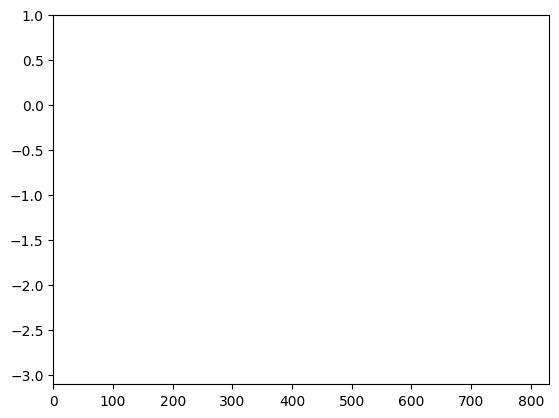

In [189]:
if EVALUATE:    
    fig, ax = plt.subplots()
    xdata, ydata = [], []

    line, = ax.plot([], [], lw=2)


    def init():
        ax.set_xlim(0, len(pkl) + 5)
        ax.set_ylim(pkl.min(), 1)
        return line,


    def update(frame):
        xdata.append(int(frame) - 1)

        ydata.append(pkl[int(frame) - 1, 0])
        line.set_data(xdata, ydata)
        return line,


    ani = FuncAnimation(fig, update, frames=np.linspace(0, len(pkl) - 1, len(pkl), endpoint=False),
                        init_func=init, blit=True, interval=20, repeat=False)

In [190]:
if EVALUATE:
    %time ani.save('anim-mario.gif', writer='imagemagick', fps=25)

CPU times: user 58.9 s, sys: 1.38 s, total: 1min
Wall time: 1min


In [193]:
HTML('<img src="anim-mario.gif" />')

# Render Video & Calculate Score

In [39]:
def preprocess_state(stacked_state, state, new_episode):
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    state = cv2.resize(state, (84, 84), interpolation=cv2.INTER_AREA)
    
    if new_episode:
        stacked_state = np.stack([state for _ in range(4)], axis=0)
    else:
        stacked_state = stacked_state[1:, ...]
        stacked_state = np.concatenate([stacked_state, np.expand_dims(state, axis=0)], axis=0)
        
    return stacked_state

In [172]:
def score_agent(env, max_steps, n_eval_episodes, agent):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param agent: The trained agent
  """
  episode_rewards = []
  out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 60.0, 
                          env.observation_space.shape[1::-1])

  for episode in range(n_eval_episodes):
    s, info = env.reset()

    state = np.zeros((84, 84, 4), dtype=np.uint8)
    state = preprocess_state(state, s, True)
    
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
        state_exp = np.expand_dims(state, 0)
        # Take the action (index) that have the maximum expected future reward given that state
        action, *_ = agent.get_action(np.float32(state_exp) / 255.)

        s_, reward, terminated, truncated, info = env.step(action.item()) # We directly put next_state = state for recording logic
        out.write(cv2.cvtColor(s_, cv2.COLOR_RGB2BGR))
        total_rewards_ep += reward
        
        if terminated or truncated: 
            env.reset()
            break

        state = preprocess_state(state, s_, False)
    
    episode_rewards.append(total_rewards_ep)
  
  out.release()
  os.system('ffmpeg -i output.mp4 replay.mp4 -y')
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [173]:
eval_env = JoypadSpace(gym_super_mario_bros.make(env_id,  
                                                 apply_api_compatibility=True, 
                                                 render_mode='rgb_array'), COMPLEX_MOVEMENT)
score_agent(eval_env, max_step_per_episode, 1, agent)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

(1468.0, 0.0)

In [175]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="480" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

embed_mp4('/kaggle/working/replay.mp4')

# Push to Huggingface

In [176]:
from huggingface_hub import notebook_login, login
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json

import tempfile

## Push Function

In [177]:
def push_to_hub(repo_id, model, hyperparameters, eval_env, video_fps=30):
  """
  Evaluate, Generate a video and Upload a model to Hugging Face Hub.
  This method does the complete pipeline:
  - It evaluates the model
  - It generates the model card
  - It generates a replay video of the agent
  - It pushes everything to the Hub

  :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
  :param model: the pytorch model we want to save
  :param hyperparameters: training hyperparameters
  :param eval_env: evaluation environment
  :param video_fps: how many frame per seconds to record our video replay
  """

  _, repo_name = repo_id.split("/")
  api = HfApi()

  # Step 1: Create the repo
  repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
  )

  with tempfile.TemporaryDirectory() as tmpdirname:
    local_directory = Path(tmpdirname)

    # Step 2: Save the model
    torch.save(model, local_directory / "agent.pt")
    
    print('Agent Saved')

    # Step 3: Save the hyperparameters to JSON
    with open(local_directory / "hyperparameters.json", "w") as outfile:
      json.dump(hyperparameters, outfile)

    # Step 4: Evaluate the model and build JSON
    mean_reward, std_reward = score_agent(eval_env,
                                            hyperparameters["maxstepperepisode"],
                                            10,
                                            model)
    
    print('Agent Score Saved')
    
    # Get datetime
    eval_datetime = datetime.datetime.now()
    eval_form_datetime = eval_datetime.isoformat()

    evaluate_data = {
          "env_id": hyperparameters["envid"],
          "mean_reward": mean_reward,
          "n_evaluation_episodes": 10,
          "eval_datetime": eval_form_datetime,
    }

    # Write a JSON file
    with open(local_directory / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = hyperparameters["envid"]

    metadata = {}
    metadata["tags"] = [
          env_name,
          "RND","CNN",
          "reinforcement-learning",
          "custom-implementation",
          "atari",
          "SuperMarioBros-v0"
      ]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
      )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **RND with CNN** Agent playing **{env_id}**
  This is a trained model of a **RND-CNN** agent playing **{env_id}** .
  To learn to use this model and train yours check this notebook on kaggle: https://www.kaggle.com/code/syedjarullahhisham/drl-extra-personal-unit-5-rnd-super-mario-bros
  """

    readme_path = local_directory / "README.md"
    readme = ""
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
          readme = f.read()
    else:
      readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
      f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    import shutil
    video_path =  local_directory / "replay.mp4"
    shutil.copy('replay.mp4', video_path)
    
    print('Agent Video Saved')

    # Step 7. Push everything to the Hub
    api.upload_folder(
          repo_id=repo_id,
          folder_path=local_directory,
          path_in_repo=".",
    )

    print(f"Your model is pushed to the Hub. You can view your model here: {repo_url}")

## HF Login 

In [181]:
notebook_login()
!git config --global credential.helper store

## Final Push 

In [179]:
mario_hyperparameters = {
    "trainmethod": train_method,
    "envid": env_id,
    "maxstepperepisode": max_step_per_episode,
    "learningrate": learning_rate,
    "numenv": num_worker,
    "numstep": num_step,
    "gamma": gamma,
    "intgamma": int_gamma,
    "lambda": lam,
    "usegae": use_gae,
    "clipgradnorm": clip_grad_norm,
    "entropy": entropy_coef,
    "epoch": epoch,
    "minibatch": mini_batch,
    "ppoeps": ppo_eps,
    "extcoef": ext_coef,
    "intcoef": int_coef,
    "stickyaction": sticky_action,
    "actionprob": action_prob,
    "lifedone": life_done,
    "obsnormstep": pre_obs_norm_step,
}

In [180]:
repo_id = "hishamcse/RND-SuperMarioBros-v0"
eval_env = JoypadSpace(gym_super_mario_bros.make(env_id,  
                                                 apply_api_compatibility=True, 
                                                 render_mode='rgb_array'), COMPLEX_MOVEMENT)

push_to_hub(repo_id,
                agent, # The model we want to save
                mario_hyperparameters, # Hyperparameters
                eval_env, # Evaluation environment
                video_fps=50
                )

Agent Saved


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Agent Score Saved
Agent Video Saved


replay.mp4:   0%|          | 0.00/4.93M [00:00<?, ?B/s]

Your model is pushed to the Hub. You can view your model here: https://huggingface.co/hishamcse/RND-SuperMarioBros-v0
